# Impacting factors on land values
### Definitions
- ```p_m2_FE```: Weighted average price of invididual transactions per four-digit zipcode area for the period 1985-2007, indexed towards the 2007 price-level.

### Module loading and configuration

In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from sklearn.linear_model import LinearRegression
from ipywidgets import interact_manual
import ipywidgets as widgets

In [2]:
from variables import data_labels, m

In [3]:
plt.rcParams['figure.dpi'] = 300

## Chapter 1: Data
- Import the main shapefile from CBS containing postal codes and key data per postal code.
- Add the data from Weighted_avg_landprice_pc4_1985-2007 to the DataFrame
- Calculate land area (km2) from shapefile and determine population density (pop_density) using this area
- Set PC4 as DataFrame index

In [4]:
data = geopandas.read_file('data/cbs_pc4_2018_v3.shp')
data.replace(-99997, np.nan, inplace=True)

Weighted_avg_landprice_pc4 = pd.read_excel('data/Weighted_avg_landprice_pc4_1985-2007.xls', sheet_name='Data')
data = pd.merge(data, Weighted_avg_landprice_pc4, left_on='PC4', right_on='PC4Code', suffixes=(None,'_VU')).drop('PC4Code', axis=1)

data['km2'] = data.to_crs('epsg:32633').geometry.area / 1_000_000 
data['pop_density'] = data.INWONER/data.km2  
data = data.set_index('PC4')

## Chapter 2: Introduction
To begin with analysis we can look at how average land rent is distributed throughout the country.
### 2.1 Plot a column from the GeoPandas DataFrame to a map

In [5]:
def plot(column, n):
    '''Plot column of the dataset to a map on a 4-digit zipcode level'''
    data.plot(column=column, legend=True, norm=matplotlib.colors.LogNorm(vmin=data[column].min(), vmax=data[column].max()))
    ax = plt.gca()
    ax.set_title('Figure ' + n + ': ' + data_labels.get(column, column) + ' on 4-digit zipcode level')
    ax.set_axis_off()
    plt.show()

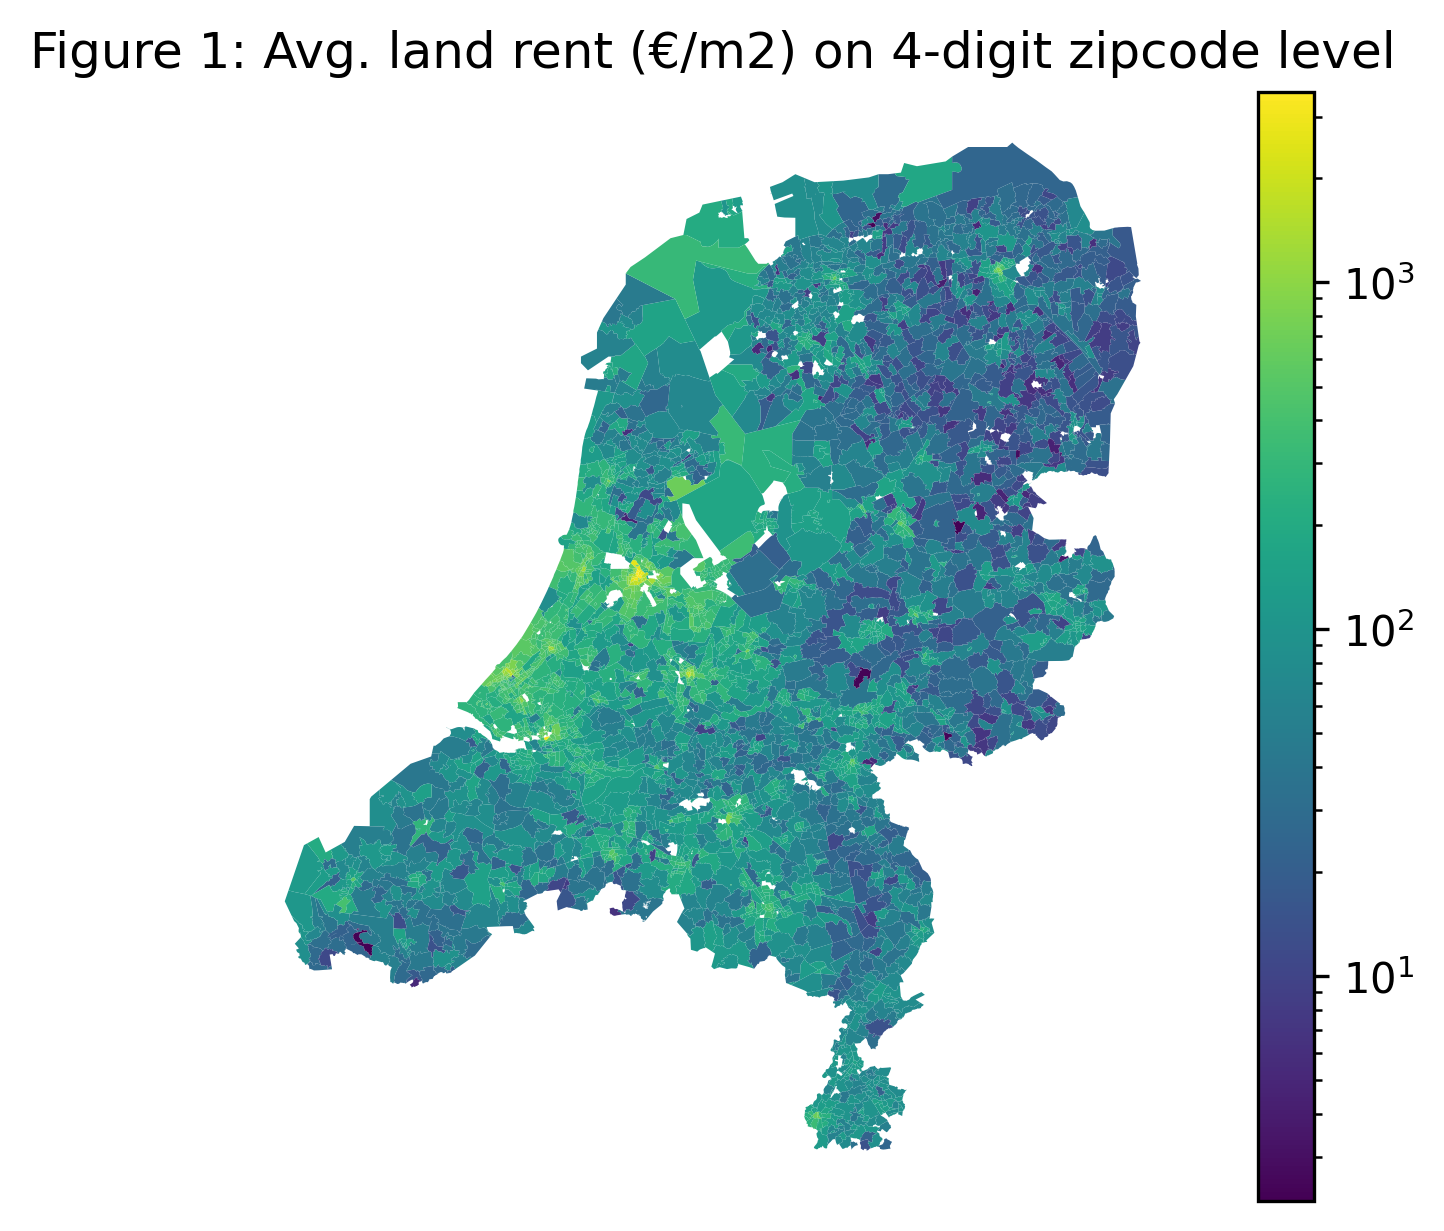

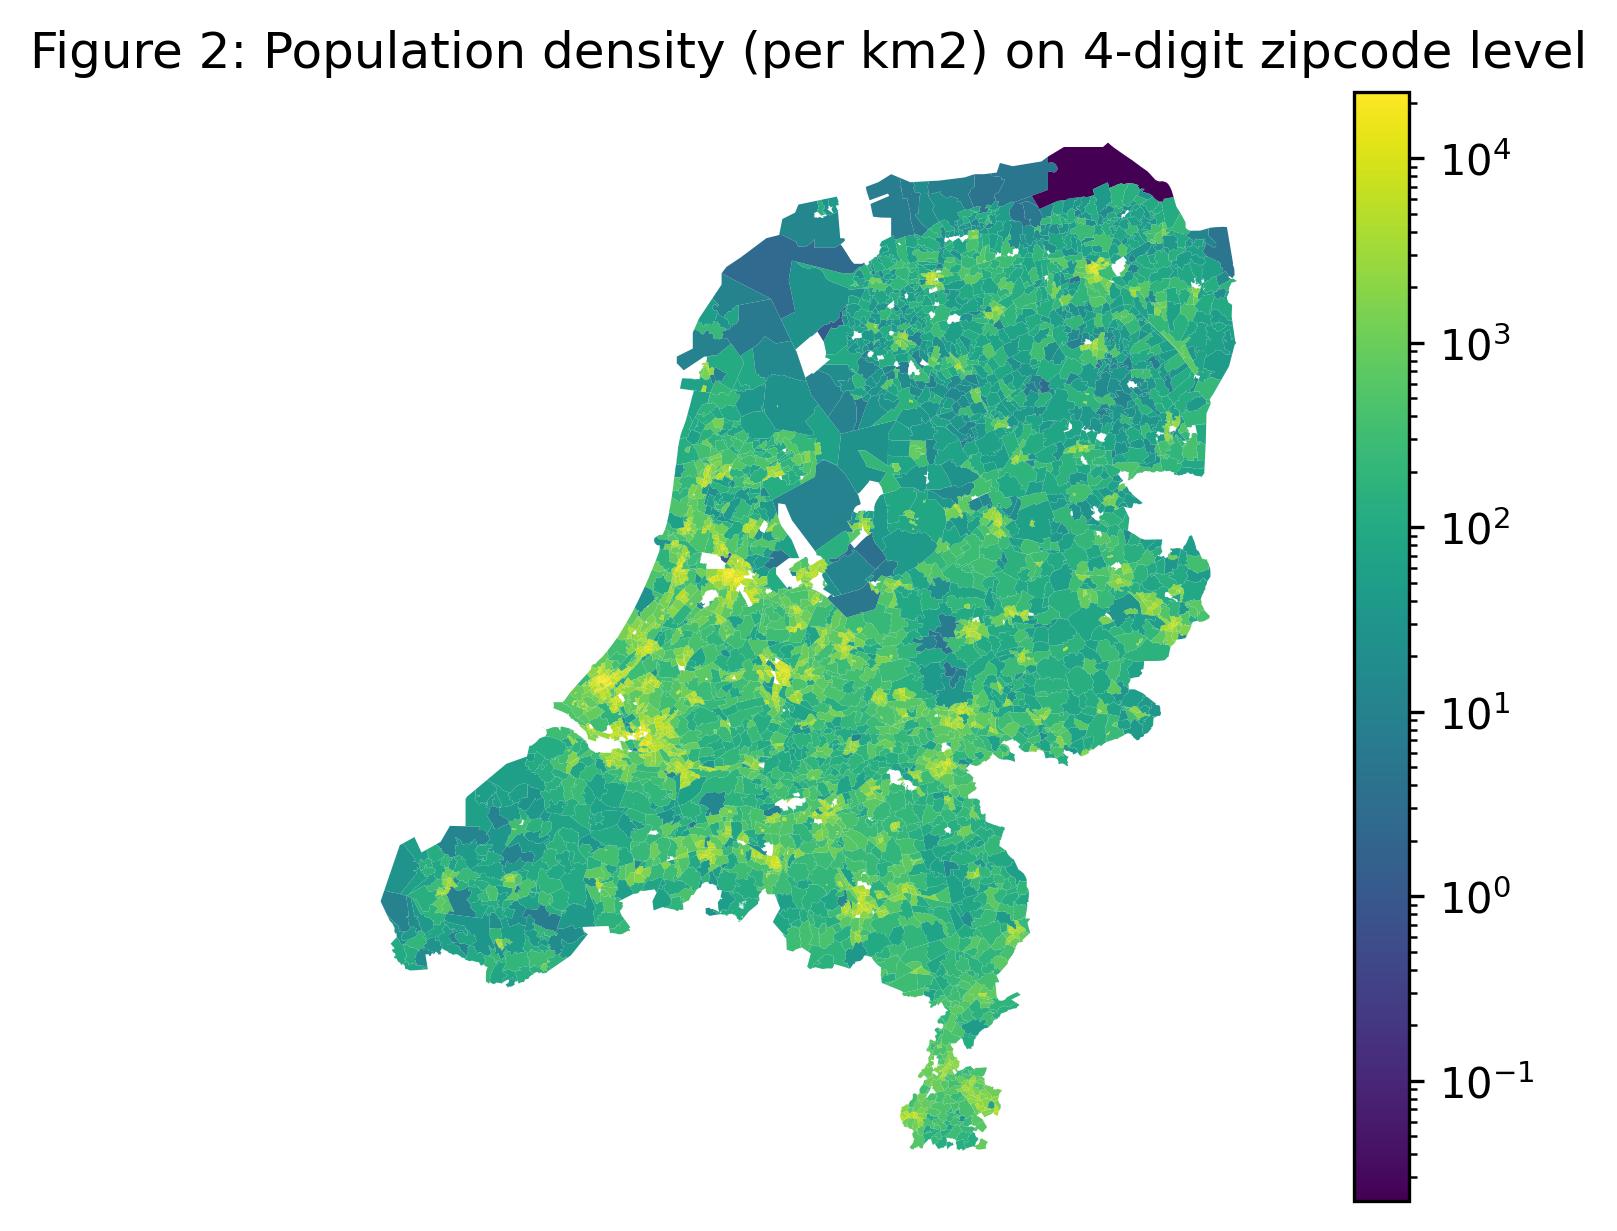

In [6]:
plot('p_m2_FE', '1')
plot('pop_density', '2')

## 2.2 Plot the correlation between a column to land rent
Figure 1 shows that land rent is higher around major cities such as Amsterdam, Den Haag, Rotterdam and Utrecht. Figure 2 shows that these areas are also densely populated. We can vissualize how different factors influence this by plotting their correlation to the land rent.

In [7]:
def plot_relation(data, column, title=''):
    '''Plot a log log scatter plot of column to p_m2_FE from data 
    and draw a Ordinary Least Squares (OLS) regression trendline'''
    data_temp = data.dropna(subset=column)

    fig = px.scatter(data_temp, x=column, y='p_m2_FE', trendline="ols", log_x=True, log_y=True,
                     trendline_options=dict(log_x=True, log_y=True), trendline_color_override='red',
                     labels=data_labels, title=title)
    fig.show()

In [8]:
plot_relation(data, 'pop_density', 'Figure 3: Land rent is related to population density')
plot_relation(data[data['STED'] == 1], 'pop_density', 'Figure 4: Within cities this relation is weaker')

In [9]:
plot_relation(data, 'AFS_BIOS', 'Figure 5: Land rent seems to be correlated to afstand tot dichstbijzijnde bioscoop')

## Chapter 3: Linear Regression models
### 3.1 Coefficients in a Linear Regression model
Figures 3-5 show correlation between the average land rent and population density (3-4) and ```afstand tot dichtsbijzijnde bioscoop``` (5). However, a correlation does not necessarily mean a causal effect. To better analyse how the different factors together influence land rent a Linar Regression model can be used.

In [10]:
def coeff_df(dataset, m):
    '''Fit a Linear Regression model of factors m of dataset and return the R^2 score and a DataFrame of coefficients'''
    X = dataset.dropna(subset=m)[m]
    y = dataset.dropna(subset=m)['p_m2_FE']
    reg = LinearRegression().fit(X, y)
    
    return reg.score(X,y), pd.DataFrame(reg.coef_, X.columns, columns=['Coefficients'])

In [11]:
score, coeff = coeff_df(data, m[0])
print(f'R^2 = {score}')
display(coeff)

R^2 = 0.6087651432885118


Coefficients
AFS_BSO        -0.563265
AFS_HAPRAK      1.551114
AFS_TRNOVS      0.347566
AFS_ONDHV      -1.903165
AFS_WARENH     -1.322460
AFS_APOTH      -2.320287
AFS_TREINS      0.812268
AFS_BRANDW     -4.182794
AFS_CAFE        7.000550
AFS_POP        -2.084325
AFS_KDV        -7.170467
AV5_HAPRAK      6.988565
AFS_HOTEL      -2.249264
AFS_ONDBAS      0.203081
AFS_ZONBNK      0.610644
AFS_CAFTAR      0.225315
AFS_ONDVRT    -10.294759
AFS_SAUNA       0.735855
AFS_PODIUM     -0.579590
AV5_ONDBAS     -4.886903
AFS_OPRIT       2.968217
OAD             0.072518
AV5_SUPERM      2.304458
AF_IJSBAAN     -0.493930
AFS_MUS        -1.538935
AFS_ONDVMB      9.144559
AFS_ZWEMB       1.233340
AFS_SUPERM     -0.940036
AFS_ATTRAC     -0.405665
AFS_BIOS        0.244648
AFS_HAPOST      1.199484
AV5_ONDVRT     -4.674024
AFS_DAGLMD     -1.457968
AFS_BIBLIO      1.942149
AFS_ZIEK_E      0.451967
AFS_ZIEK_I     -1.031361
G_ELEK_WON      0.004568

Figure 5 showed a negative correlation between land rents and ```afstand tot dichtsbijzijnde bioscoop```, however the Linear Regression coefficient shows a positive effect. The negative correlation is most likely caused by other factors that are closely correlated to ```afstand tot dichtsbijzijnde bioscoop```.
### 3.2 Decomposition analysis
The Linear Regression model can be used to decompose the effect that the factors have on the land value in a specific location compared to another location (in this case the average). This decomposition is done by comparing the land rents between the location and the average and the predicted land rent compared to the predicted land rent if the factor was that of the average. A residue remains that is not explained by the Linear Regression model as it is not perfect.
- ```decompose``` plots the decomposition (by factors m) of the land rent compared to the average.
- ```factor_map``` plots the decomposed effect of a factor on land rent compared to the average for all postal codes.

In [12]:
def decompose(location, m):
    '''Plot the decomposition of the land value increase compared to the average as effected by factors m'''
    m = list(m)
    dataset = data.copy()
    X = dataset.dropna(subset=m)[m]
    y = dataset.dropna(subset=m)["p_m2_FE"]
    reg = LinearRegression().fit(X, y)

    X = dataset[m]

    x_plot = []
    y_plot = []

    for factor in m:
        X_compare = X.copy()
        X_compare.loc[location, factor] = dataset[factor].mean()

        predict = reg.predict(X.loc[[location]])
        predict_mean = reg.predict(X_compare.loc[[location]])

        x_plot.append(predict[0] - predict_mean[0])
        y_plot.append(data_labels.get(factor, factor))

    x_delta = dataset.loc[location, "p_m2_FE"] - dataset["p_m2_FE"].mean()

    residue = x_delta - sum(x_plot)

    x_plot.append(residue)
    y_plot.append("Residue")

    x_plot.append(x_delta)
    y_plot.append("Difference in land values")

    fig = go.Figure(go.Bar(x=x_plot, y=y_plot, orientation="h"))
    fig.update_yaxes(tickmode="linear")
    fig["data"][0].width = 1
    title = f"Effect of factors on land values in postal code {str(location)} compared to average"
    fig.update_layout(title_text=title)
    fig.show()


def factor_map(factor, m):
    '''Plot a map which plots the effect of factor as determined by a Linear Regression model which takes m as input'''
    dataset = data.copy()
    m = list(m)
    X = dataset.dropna(subset=m)[m]
    y = dataset.dropna(subset=m)["p_m2_FE"]
    reg = LinearRegression().fit(X, y)

    X = dataset[m]

    plot = {"PC": [], "Delta": [], "Geometry": []}

    for location in list(dataset.index):
        X_compare = X.copy()
        X_compare.loc[location, factor] = dataset[factor].mean()

        predict = reg.predict(X.loc[[location]])
        predict_mean = reg.predict(X_compare.loc[[location]])

        dataset.loc[location, factor] = predict[0] - predict_mean[0]

    dataset.plot(
        column=factor,
        legend=True,
    )
    ax = plt.gca()
    ax.set_title("Effect of " + data_labels.get(factor, factor) + " on land rents")
    ax.set_axis_off()
    plt.show()


## Decomposition dashboard
- An interactive dashboard is made where a postal code can be entered and the different factors for the Linear Regression model can be selected.

In [13]:
interact_manual(decompose,
                location=widgets.BoundedIntText(
    value=1111,
    min=1000,
    max=9999,
    step=1,
    description='Postal code:',
    disabled=False
),
                m = widgets.TagsInput(
    allowed_tags=m[0],
    value=['AV5_SUPERM', 'AFS_OPRIT', 'AFS_TREINS', 'AV5_HAPRAK', 'AV5_ONDBAS', 'AV5_ONDVRT', 'AFS_PODIUM', 'OAD'],
    description='Factors:',
    disabled=False
))



interactive(children=(BoundedIntText(value=1111, description='Postal code:', max=9999, min=1000), TagsInput(va…

<function __main__.decompose(location, m)>

## Effect map dashboard
- An interactive dashboard is made where a factor can be selected and the factors m for the Linear Regression model can be selected to map the effect of factor in all postal codes.

In [14]:
interact_manual(
    factor_map,
    factor=widgets.Combobox(
        placeholder="Choose factor",
        options=m[0],
        description="Factor:",
    ),
    m=widgets.TagsInput(
        allowed_tags=m[0],
        value=[
            "AV5_SUPERM",
            "AFS_OPRIT",
            "AFS_TREINS",
            "AV5_HAPRAK",
            "AV5_ONDBAS",
            "AV5_ONDVRT",
            "AFS_PODIUM",
            "OAD",
        ],
    ),
)


interactive(children=(Combobox(value='', description='Factor:', options=('AFS_BSO', 'AFS_HAPRAK', 'AFS_TRNOVS'…

<function __main__.factor_map(factor, m)>